In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, kstest
from scipy.integrate import cumulative_trapezoid

Avg fraction of limits per dataset: 0.4902866666666667
PIT mean (should be ~0.5): 0.47171702176904917


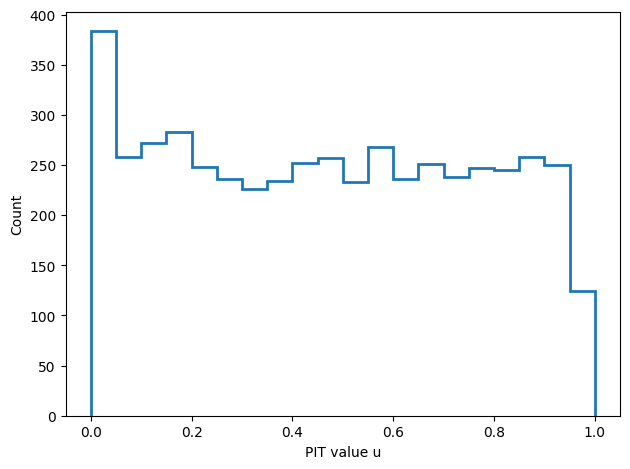

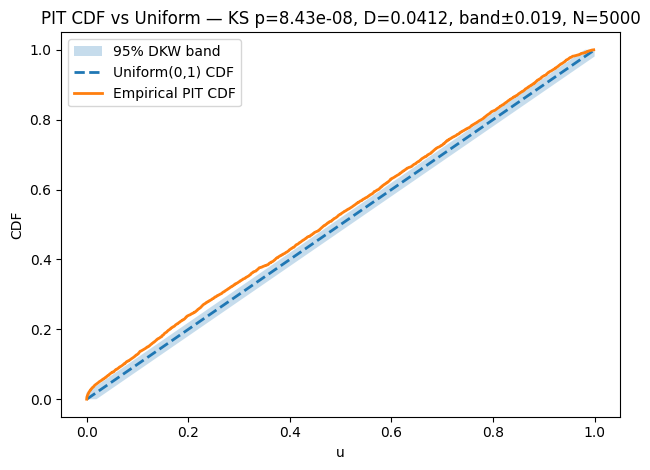

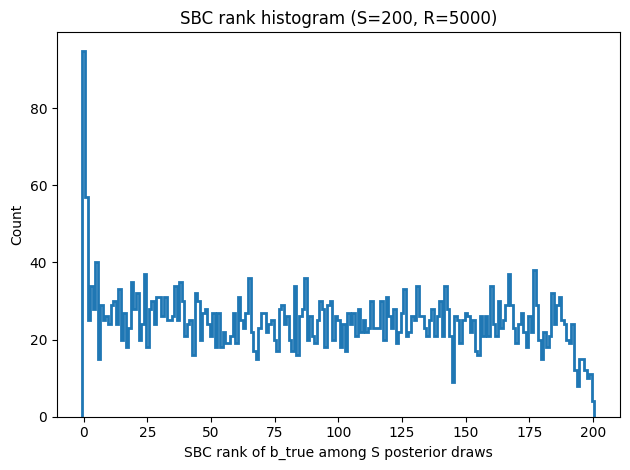

In [ ]:
# ============================================================
# 1) Problem setup: infer intercept b with fixed scatter sigma
#    y ~ Normal(b, sigma^2)
#    reporting: detection if y_obs >= L else upper limit (y_obs < L)
#    prior: b ~ Uniform(b_min, b_max)
# ============================================================

# ----- knobs -----
sigma = 0.5         # fixed total scatter
L = 0.0             # detection threshold
Npts = 30           # datapoints per dataset
R = 5000            # number of SBC/PIT replications
S = 200             # posterior draws per replication for SBC rank histogram
alpha_band = 0.05   # DKW band level (0.05 => 95% simultaneous band)

# Uniform prior support (MUST match grid)
b_min, b_max = -20.0, 20.0

# Grid for posterior representation
Nb = 20001  # increase if posterior gets sharp (e.g., small sigma, large Npts)
bgrid = np.linspace(b_min, b_max, Nb)
db = bgrid[1] - bgrid[0]

# Constant prior on the grid (for uniform it cancels, but we keep it explicit)
prior = np.ones_like(bgrid) / (b_max - b_min)

rng = np.random.default_rng(0)

def simulate_dataset(rng):
    """Draw b_true from prior, simulate y, return (b_true, y, is_limit)."""
    b_true = rng.uniform(b_min, b_max)
    y = rng.normal(b_true, sigma, size=Npts)
    is_limit = y < L
    return b_true, y, is_limit

def posterior_on_grid(y, is_limit):
    """Correct posterior for b on a grid using detections + upper limits."""
    loglike = np.zeros_like(bgrid)

    det = ~is_limit
    if det.any():
        # product of Normal pdfs -> sum of logpdfs
        loglike += np.sum(
            norm.logpdf(y[det][:, None], loc=bgrid[None, :], scale=sigma),
            axis=0,
        )

    lim = is_limit
    if lim.any():
        # for each limit: P(y < L | b) = Phi((L - b)/sigma)
        loglike += np.sum(
            norm.logcdf((L - bgrid)[None, :] / sigma),
            axis=0,
        )

    # posterior ∝ prior * likelihood; with uniform prior this is just likelihood up to const
    logpost = np.log(prior) + loglike
    logpost -= np.max(logpost)  # stabilize
    post = np.exp(logpost)

    # normalize on grid
    post /= (post.sum() * db)
    return post

def pit_from_post(post, b_true, rng):
    """
    PIT u = F_post(b_true), computed with trapezoid CDF + randomized jitter
    within the grid interval to avoid discretization pile-ups.
    """
    F = cumulative_trapezoid(post, bgrid, initial=0.0)
    F /= F[-1]  # guard against tiny drift

    j = np.searchsorted(bgrid, b_true)
    if j <= 0:
        return 0.0
    if j >= len(bgrid):
        return 1.0

    F0, F1 = F[j - 1], F[j]
    return F0 + rng.random() * (F1 - F0)

def sbc_rank_from_post(post, b_true, rng, S):
    """
    Simulation-based calibration (rank statistic):
    draw S posterior samples of b, compute rank of b_true among them.
    Should be Uniform on {0,...,S}.
    """
    # discrete sampling from grid approximation
    p = post * db
    p /= p.sum()

    samples = rng.choice(bgrid, size=S, replace=True, p=p)

    # rank with random tie-breaking (important with grid samples)
    less = np.sum(samples < b_true)
    equal = np.sum(samples == b_true)
    rank = less + rng.integers(0, equal + 1)  # uniform among ties
    return rank

# ============================================================
# 2) Run SBC/PIT
# ============================================================

u = np.empty(R)
ranks = np.empty(R, dtype=int)
frac_limits = np.empty(R)

for r in range(R):
    b_true, y, is_limit = simulate_dataset(rng)
    frac_limits[r] = is_limit.mean()

    post = posterior_on_grid(y, is_limit)
    u[r] = pit_from_post(post, b_true, rng)
    ranks[r] = sbc_rank_from_post(post, b_true, rng, S)

print("Avg fraction of limits per dataset:", frac_limits.mean())
print("PIT mean (should be ~0.5):", u.mean())

# ============================================================
# 3) PIT histogram
# ============================================================

bins = np.linspace(0, 1, 21)
plt.figure()
plt.hist(u, bins=bins, histtype="step", linewidth=2)
plt.xlabel("PIT value u")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# ============================================================
# 4) PIT CDF vs Uniform CDF + DKW confidence band + KS test
# ============================================================

# KS test vs Uniform(0,1)
ks = kstest(u, "uniform")
D, pval = ks.statistic, ks.pvalue

# Empirical CDF
u_sorted = np.sort(u)
ecdf = np.arange(1, len(u_sorted) + 1) / len(u_sorted)

# DKW band around uniform CDF: |Fn(u) - u| <= eps with prob >= 1-alpha_band
n = len(u_sorted)
eps = np.sqrt(np.log(2 / alpha_band) / (2 * n))
grid = np.linspace(0, 1, 2000)
lower = np.clip(grid - eps, 0, 1)
upper = np.clip(grid + eps, 0, 1)

plt.figure()
plt.fill_between(grid, lower, upper, alpha=0.25, label=f"{int((1-alpha_band)*100)}% DKW band")
plt.plot([0, 1], [0, 1], "--", linewidth=2, label="Uniform(0,1) CDF")
plt.plot(u_sorted, ecdf, linewidth=2, label="Empirical PIT CDF")
plt.xlabel("u")
plt.ylabel("CDF")
plt.title(f"PIT CDF vs Uniform — KS p={pval:.3g}, D={D:.4f}, band±{eps:.3f}, N={n}")
plt.legend()
plt.tight_layout()
plt.show()

# ============================================================
# 5) SBC rank histogram
# ============================================================

rank_bins = np.arange(S + 2) - 0.5  # centers bins on integers 0..S
plt.figure()
plt.hist(ranks, bins=rank_bins, histtype="step", linewidth=2)
plt.xlabel("SBC rank of b_true among S posterior draws")
plt.ylabel("Count")
plt.title(f"SBC rank histogram (S={S}, R={R})")
plt.tight_layout()
plt.show()
